In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
save_name='indian_pines_all'
df = pd.read_csv(f'{save_name}.csv')
df.columns

Index(['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8',
       'band9', 'band10',
       ...
       'band192', 'band193', 'band194', 'band195', 'band196', 'band197',
       'band198', 'band199', 'band200', 'class'],
      dtype='object', length=201)

In [4]:
class_labels = {'1':'Alfalfa',
                '2':'Corn-notill',
                '3':'Corn-mintill',
                '4':'Corn',
                '5':'Grass-pasture',
                '6':'Grass-trees',
                '7':'Grass-pasture-mowed',
                '8':'Hay-windrowed',
                '9':'Oats',
                '10':'Soybean-notill',
                '11':'Soybean-mintill',
                '12':'Soybean-clean',
                '13':'Wheat',
                '14':'Woods',
                '15':'Buildings-Grass-Trees-Drives',
                '16':'Stone-Steel-Towers',
               }

In [5]:
names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees',
         'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
         'Soybean-clean', 'Wheat', 'Woods', 'Buildings Grass Trees Drives', 'Stone Steel Towers']

# 0.SVM
- 使用SVM在原始数据上进行分类。
- docs:https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [7]:
def svm_matrix_plot(X, y):
    """
    使用SVM对数据进行分类，绘制结果，并统计分类精度、召回率和F1分数
    ----
    param X:数据样本集（不含标签），np.array
    param y:数据集标签，np.array
    """
    # 训练集测试集划分，比例8:2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)
    # 实例化分类器，核函数：径向基函数（高斯核）
    svm = SVC(C=100, kernel='rbf', cache_size=10*1024)
    # 训练分类器
    svm.fit(X_train, y_train)
    # 测试集的预测结果
    ypred = svm.predict(X_test)
    
    # 分类结果的混淆矩阵
    conf_matrix = confusion_matrix(y_test, ypred)
    df_cm = pd.DataFrame(conf_matrix, columns=np.unique(names), index = np.unique(names))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    
    plt.figure(figsize = (10,8))
    sns.set(font_scale = 1.4)#for label size
    sns.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
    
    return svm, y_test, ypred

In [9]:
def plot_classify(svm, q, save_name='IP_cmap'):
    """
    绘制分类结果
    ----
    param svm：训练好的svm分类器
    param q：数据集，DataFrame
    """
    l=[]
    for i in range(q.shape[0]):
        if q.iloc[i, -1] == 0:
            l.append(0)
        else:
            l.append(svm.predict(q.iloc[i, :-1].values.reshape(1, -1))[0])

    clmap = np.array(l).reshape(145, 145).astype('float')
    plt.figure(figsize=(10, 8))
    plt.imshow(clmap, cmap='nipy_spectral')
    plt.colorbar()
    plt.axis('off')
    plt.savefig(f'./results/{save_name}.png')
    plt.show()

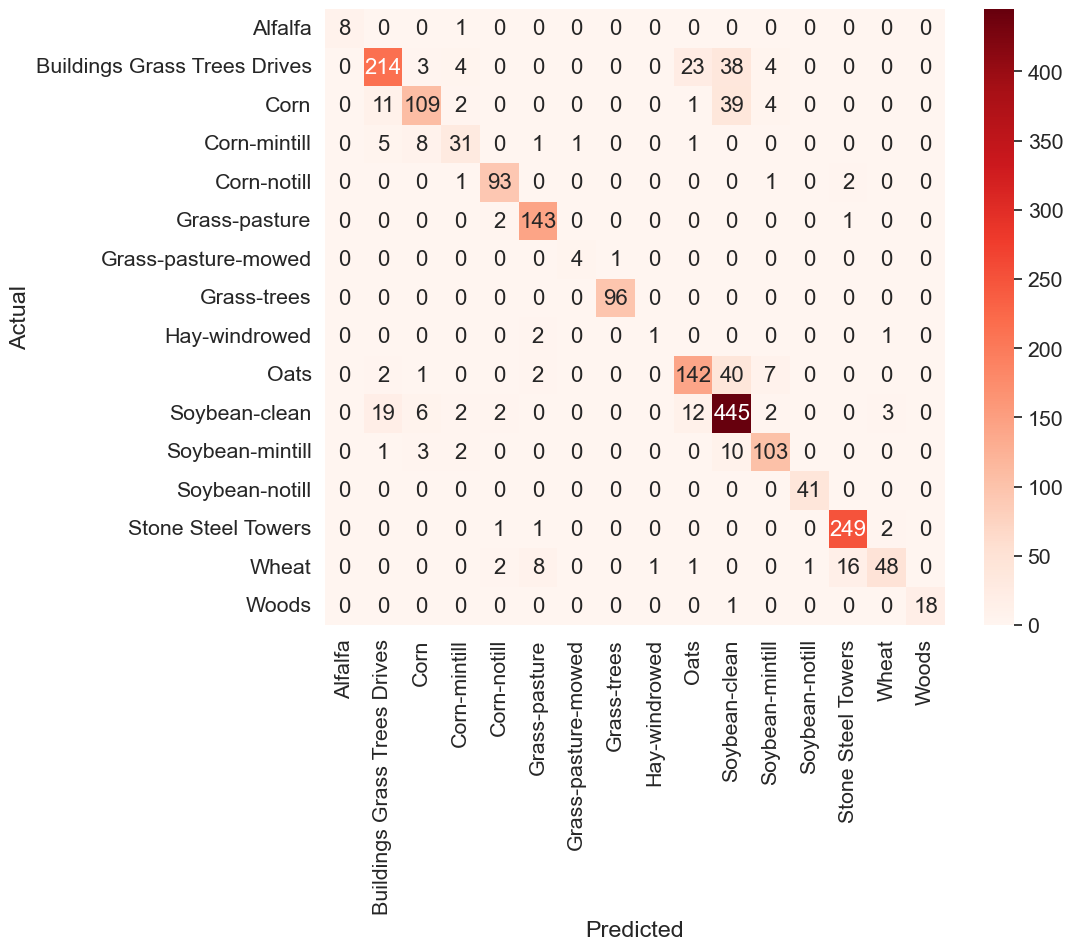

In [10]:
# 去除掉背景（0类）
x = df[df['class'] != 0]
X = x.iloc[:, :-1].values
y = x.iloc[:, -1].values

svm, y_test, ypred = svm_matrix_plot(X, y)

In [11]:
print(classification_report(y_test, ypred, target_names = names))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.85      0.75      0.80       286
                Corn-mintill       0.84      0.66      0.74       166
                        Corn       0.72      0.66      0.69        47
               Grass-pasture       0.93      0.96      0.94        97
                 Grass-trees       0.91      0.98      0.94       146
         Grass-pasture-mowed       0.80      0.80      0.80         5
               Hay-windrowed       0.99      1.00      0.99        96
                        Oats       0.50      0.25      0.33         4
              Soybean-notill       0.79      0.73      0.76       194
             Soybean-mintill       0.78      0.91      0.84       491
               Soybean-clean       0.85      0.87      0.86       119
                       Wheat       0.98      1.00      0.99        41
                   

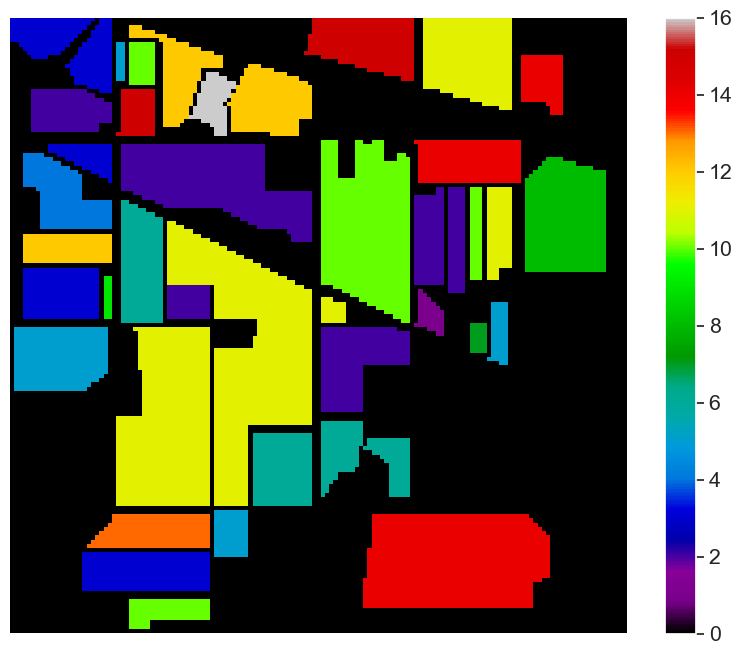

In [12]:
# 真实数据
y = pd.read_csv("df_indian_pines_gt.csv")

plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('./results/IP_cmap.png')
plt.show()

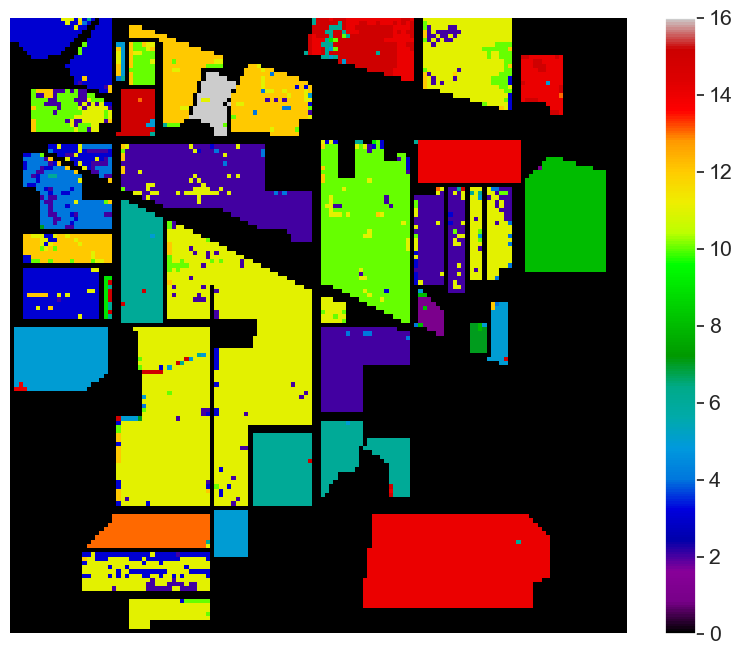

In [13]:
plot_classify(svm, df, save_name = 'IP_SVM_Orig')

# 1. PCA
- PCA:https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- KPCA:https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA
- Spares PCA:https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA

In [14]:
from sklearn.decomposition import PCA

pca_components = 50

pca = PCA(n_components = pca_components)
data = df.iloc[:, :-1].values
dt = pca.fit_transform(data)
# ev = pca.explained_variance_ratio_ # 收敛过程解释
# plt.figure(figsize=(12, 6), dpi=300)
# plt.plot(np.cumsum(ev))
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.show()

In [20]:
pca_components = 50
pca = PCA(n_components = pca_components)
pca_results = pca.fit_transform(df.iloc[:, :-1].values)
print(pca_results)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(df.iloc[:, -1])], axis = 1)
q.columns = [f'PC-{i}' for i in range(1, pca_components+1)]+['class']

q.head()

[[ 5.01490598e+03 -1.45686326e+03  7.26970489e+01 ...  2.36045485e+01
  -2.92245798e+01 -6.96797834e+01]
 [ 5.60138374e+03  2.02345009e+03  3.50134661e+02 ... -1.45420367e+01
  -2.40244749e+01 -6.76983216e+01]
 [ 5.79613544e+03  3.09039485e+03  4.90539929e+02 ...  3.64950648e+01
  -2.02684988e+01 -5.83948233e+01]
 ...
 [-7.36983420e+03  1.13238177e+03  3.98170226e+02 ...  5.48586667e-01
  -1.04893592e+02 -2.99137499e+01]
 [-6.49708724e+03 -7.98240033e+02  6.76808968e+02 ... -4.95763039e+01
   5.43084856e+01  2.91532096e+01]
 [-6.57046116e+03 -3.46749622e+02  4.65450797e+02 ...  2.34554066e+01
   4.06773800e+01 -4.77625509e+01]]


,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-42,PC-43,PC-44,PC-45,PC-46,PC-47,PC-48,PC-49,PC-50,class
0,98.502297,30.708663,26.069903,7.233416,11.701570,17.415968,4.842787,10.259332,0.936506,11.002099,...,1.999103,5.680685,13.206706,0.000000,15.509479,0.735222,0.811376,0.287176,17.600894,3
1,132.812695,42.236631,43.766803,2.266755,2.512806,24.478725,15.191789,5.836794,1.011508,3.938914,...,3.679069,1.632874,13.653684,2.066787,16.547401,1.610018,2.538943,0.243750,21.842012,3
2,138.503083,40.394695,48.238418,3.992141,1.382716,24.793601,11.921302,7.418704,0.678167,7.194929,...,2.479866,5.074774,7.652303,2.140720,21.199682,0.527228,0.567400,0.077392,17.468214,3
3,126.334629,38.956664,32.619054,6.120023,3.679857,18.987169,12.417494,5.687705,1.035905,3.167345,...,3.770088,2.835898,10.883642,3.514857,18.469959,1.982922,2.960635,0.303732,21.472389,3
4,113.888641,38.932365,33.970940,0.615732,8.623890,18.787429,6.597995,6.092269,1.133099,8.830130,...,3.412832,3.963383,14.287121,3.439235,15.912498,1.273253,1.798995,0.354782,20.850303,3


In [21]:
def plot_pca(q):
    fig = plt.figure(figsize = (20, 10))
    for i in range(1, 1+8):
        fig.add_subplot(2,4, i)
        plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(145, 145), cmap='nipy_spectral')
        plt.axis('off')
        plt.title(f'Band - {i}')

    plt.savefig('./results/IP_PCA_Bands.png')

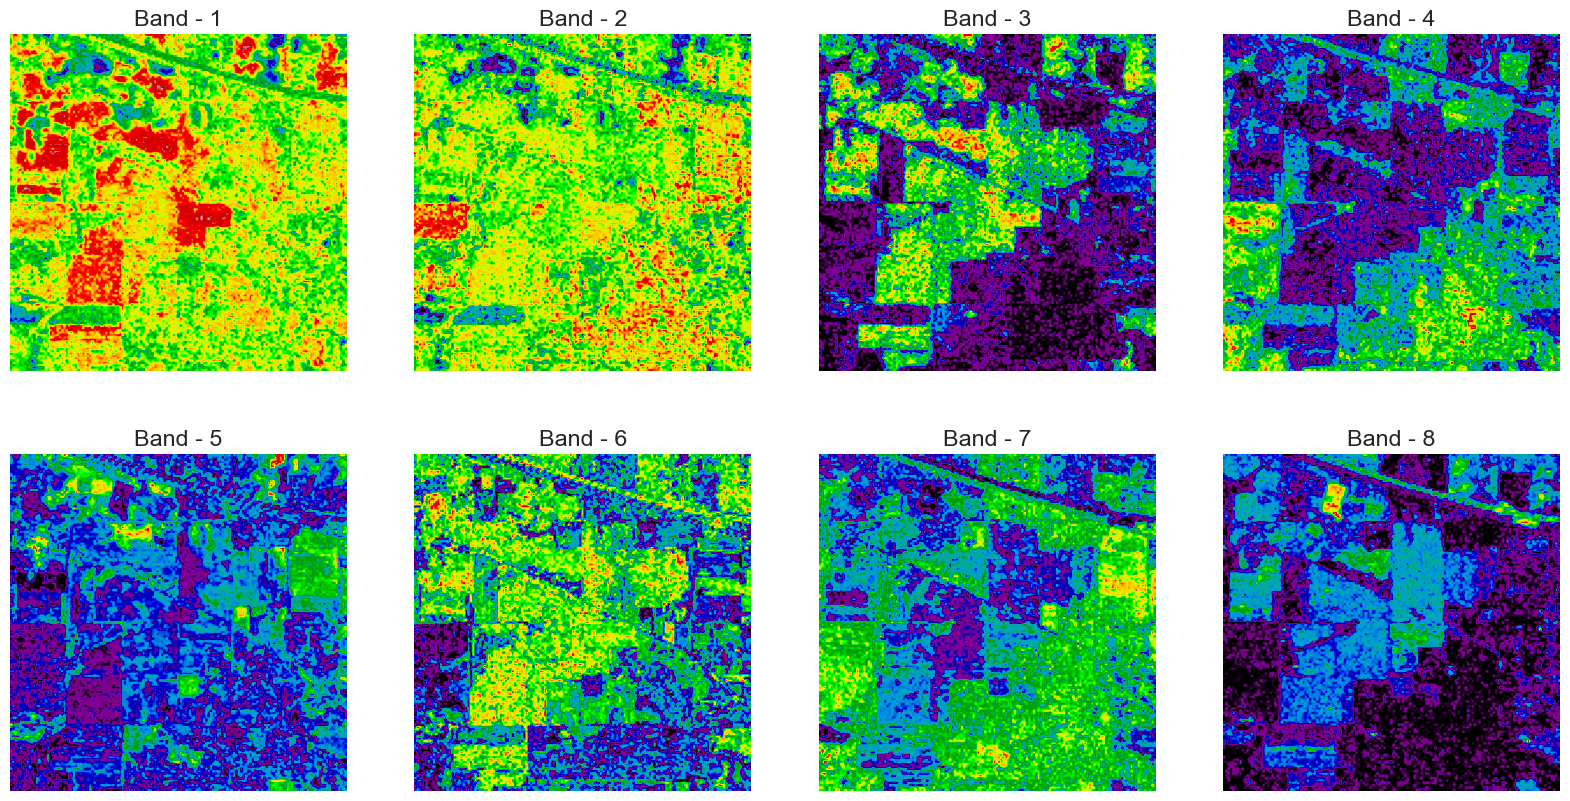

In [22]:
plot_pca(q)

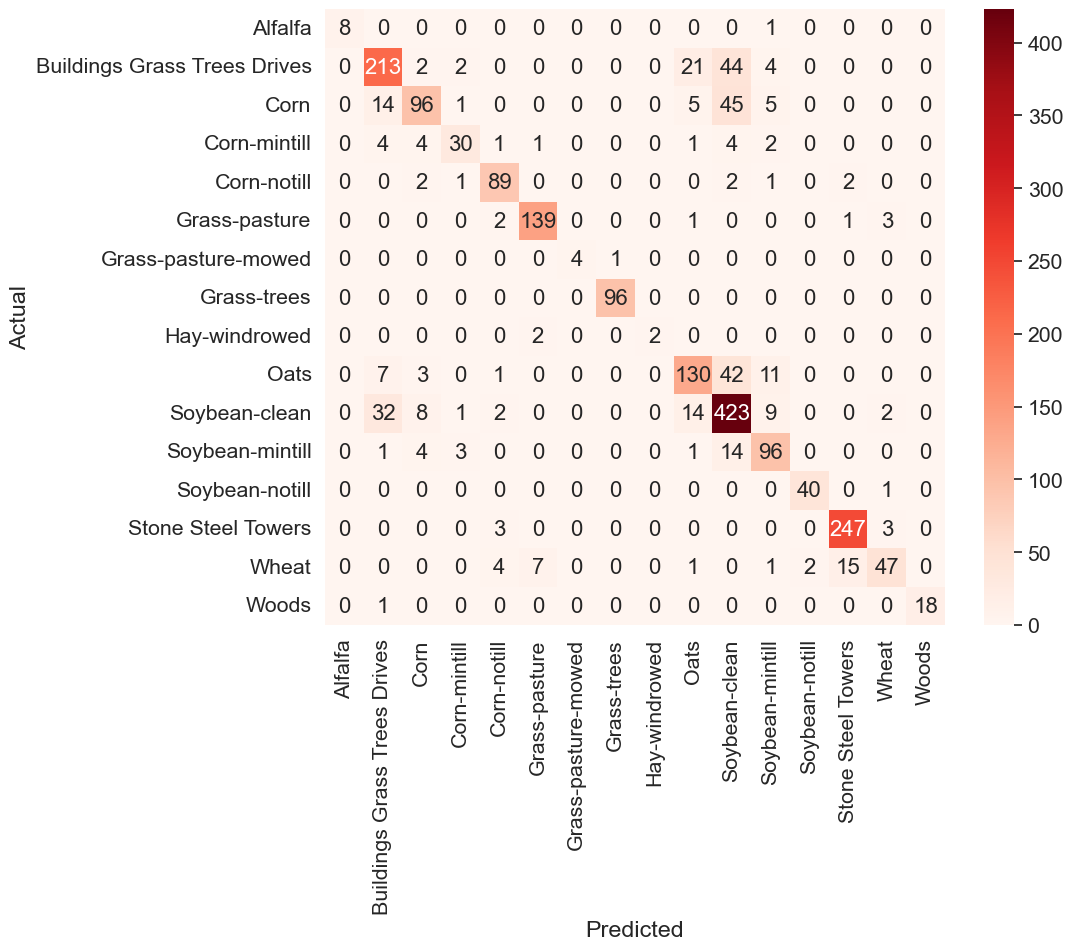

In [23]:
# 去除掉背景（0类）
x = q[q['class'] != 0]
X = x.iloc[:, :-1].values
y = x.loc[:, 'class'].values

svm, y_test, ypred = svm_matrix_plot(X, y)

In [24]:
print(classification_report(y_test, ypred, target_names = names))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.78      0.74      0.76       286
                Corn-mintill       0.81      0.58      0.67       166
                        Corn       0.79      0.64      0.71        47
               Grass-pasture       0.87      0.92      0.89        97
                 Grass-trees       0.93      0.95      0.94       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.99      1.00      0.99        96
                        Oats       1.00      0.50      0.67         4
              Soybean-notill       0.75      0.67      0.71       194
             Soybean-mintill       0.74      0.86      0.79       491
               Soybean-clean       0.74      0.81      0.77       119
                       Wheat       0.95      0.98      0.96        41
                   

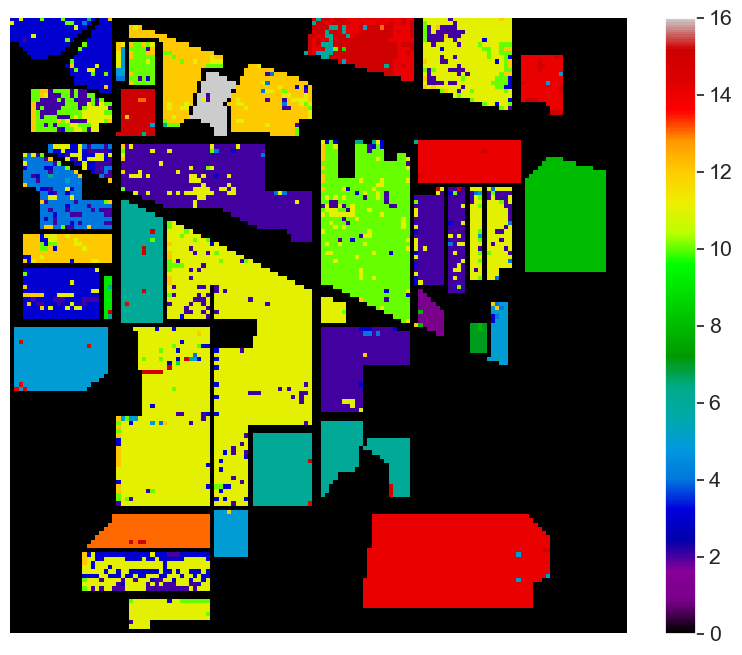

In [25]:
plot_classify(svm, q, save_name = 'IP_SVM_PCA')

# 2.KPCA 降维

In [27]:
from sklearn.datasets import load_digits
from sklearn.decomposition import KernelPCA

kpca_components = 50

transformer = KernelPCA(n_components=kpca_components,
                        kernel='rbf')

kpca_results = transformer.fit_transform(df.iloc[:, :-1].values)

q = pd.concat([pd.DataFrame(data = kpca_results), pd.DataFrame(df.iloc[:, -1])], axis = 1)

q.columns = [f'PC-{i}' for i in range(1, pca_components+1)]+['class']

q.head()

MemoryError: Unable to allocate 3.29 GiB for an array with shape (21025, 21025) and data type float64

In [ ]:
# 去除掉背景（0类）
x = q[q['class'] != 0]
X = x.iloc[:, :-1].values
y = x.loc[:, 'class'].values

svm, y_test, ypred = svm_matrix_plot(X, y)

In [ ]:
print(classification_report(y_test, ypred, target_names = names))

In [ ]:
plot_classify(svm, q, save_name = 'IP_SVM_KPCA')